
# Algoritmos de Clustering

In [1]:
# # Graficas
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
mpl.rcParams['figure.figsize'] = 16, 12

# # Lectura de base con representación TCOR
import pickle, scipy, sklearn, os
import pandas as pd
import numpy as np 
from scipy import sparse
from scipy.sparse import csr_matrix, dia_matrix
from sklearn.preprocessing import normalize
outPath = "../Output/"
WTCOR   = pickle.load(open(outPath + 'WTCOR.pickle', 'rb'))
WTCOR

<2138x37069 sparse matrix of type '<type 'numpy.float64'>'
	with 21180208 stored elements in Compressed Sparse Row format>

In [3]:
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine

# # Calculando Similitud de Coseno
pathScose = outPath + 'simCosine.pickle'
if os.path.exists(pathScose):
    simCosine = pickle.load(open(pathScose, 'rb'))
    print("--- Load cosine similarity\n")
else:
    simCosine = 1 - pairwise_distances(WTCOR, metric="cosine")
    simCosine = sparse.csr_matrix(simCosine)
    pickle.dump(simCosine, open(pathScose, 'wb'))
    print("--- Save cosine similarity\n")

--- Load cosine similarity



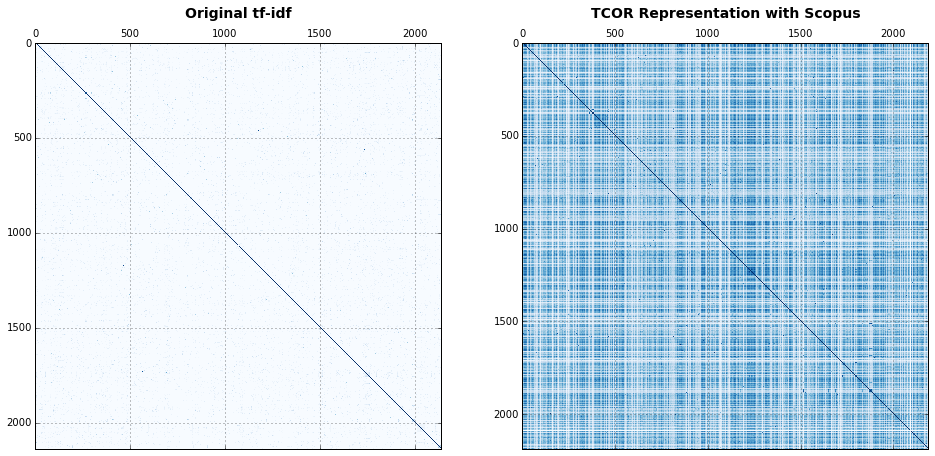

In [4]:
# # Representación Original
sin_duplicados, tfs, texts, listORF = pickle.load(open(outPath + 'tfidforig.pickle', 'rb'))
sim_orig = normalize(tfs, norm='l2')
sim_orig = sim_orig * sim_orig.T

f, (ax1, ax2) = plt.subplots(1, 2, sharey=False)
ax1.matshow(sim_orig.toarray(), cmap=plt.cm.Blues)
ax1.grid()
ax1.set_title('Original tf-idf', fontsize=14, fontweight='bold')
ax2.matshow(simCosine.toarray(), cmap=plt.cm.Blues)
ax2.grid()
ax2.set_title('TCOR Representation with Scopus', fontsize=14, fontweight='bold')

In [5]:
pd.DataFrame({'No_Cero':[len(WTCOR.getrow(dd).data) for dd in range(WTCOR.shape[0])]}).describe()

No_Cero
count   2138.000000
mean    9906.551918
std     4418.350215
min        0.000000
25%     6823.500000
50%    10254.500000
75%    13056.500000
max    24878.000000

### Cluster (Spectral Clustering, K-means (Cosine Similarity), GAAClusterer)

In [6]:
import random
import numpy as np
import collections

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from scipy.sparse import coo_matrix, vstack
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import SpectralClustering

# # Clustering con k-means sklearn
def cluster_texts_kmeansII(tfidf_model, n_clus=3):
    # # Usando la funcion del paquete Kmeans de sklearn
    km_cluster = KMeans(n_clusters=n_clus)
    km_cluster.fit(tfidf_model)
    clustering = collections.defaultdict(list)
    for idx, label in enumerate(km_cluster.labels_):
        clustering[label].append(idx)
    return clustering, km_cluster.labels_, km_cluster.cluster_centers_


def reevaluate_centers_sp(clusters):
    newmu = []
    keys = sorted(clusters.keys())
    for k in keys:
        newmu.append(np.array(vstack(clusters[k]).mean(axis = 0)[0])[0])
    return newmu

def cluster_texts_DBSCAN(sim_Mat, distriMat):
    clusters   = DBSCAN(min_samples=1).fit_predict(sim_Mat.toarray())
    clustering = collections.defaultdict(list)
    centros    = collections.defaultdict(list)
    for idx, label in enumerate(clusters):
        clustering[label].append(idx)
        centros[label].append(distriMat[idx])
    return clustering, clusters, reevaluate_centers_sp(centros)


# # Clustering con k-means sklearn
def cluster_texts_spectral(sim_Mat, distriMat, n_clus = 3):
    clusters   = SpectralClustering(n_clus, affinity = 'precomputed').fit_predict(sim_Mat.toarray())
    clustering = collections.defaultdict(list)
    centros    = collections.defaultdict(list)
    for idx, label in enumerate(clusters):
        clustering[label].append(idx)
        centros[label].append(distriMat[idx])
    return clustering, clusters, reevaluate_centers_sp(centros)

def reevaluate_centers(clusters):
    newmu = []
    keys = sorted(clusters.keys())
    for k in keys:
        newmu.append(np.mean(clusters[k], axis = 0))
    return newmu

def cluster_texts_III(tfidf_model, n_clus=3):
    # # Usando funcion de clustering de paquete Ntkl
    cluster_GAA = GAAClusterer(n_clus)
    clusters    = cluster_GAA.cluster(tfidf_model, True)
    clustering  = collections.defaultdict(list)
    centros     = collections.defaultdict(list)
    for idx, label in enumerate(clusters):
        clustering[label].append(idx)
        centros[label].append(tfidf_model[idx])
    return clustering, clusters, reevaluate_centers(centros)

In [1]:
#c1 = cluster_texts_kmeans(WTCOR, 4)[1]
#c2 = cluster_texts_kmeansII(WTCOR, n_clus= 20)
#c3 = cluster_texts_III(WTCOR, 4)[1]

In [ ]:
c2

In [ ]:
c5  = cluster_texts_DBSCAN(simCosine, WTCOR)
len(c5)

### Evaluación de los Grupos

<b> Quantization Error </b> <BR>

Esta medida mide el error que puede intrudicir la agrupación, es calculado como:

$$Q_{T}=\frac{\sum_{i=1}^{n}\left(|d(z_{i}, c_{z_{i}})|\right)^{2}}{n}$$

Donde $n$ es el cardinal del conjunto de datos, $z_{i}$ es el i-esimo elemento de la colección y $c_{z_{i}}$ es el centroide del grupo al que pertenece $z_{i}$.

![Alt text](Images_DOC\Quantization-Error.png)

In [7]:
from scipy.sparse.linalg import norm

def dis_sim(a,b): 
    if (sparse.issparse(a) or sparse.issparse(b)):
        a = sparse.csr_matrix(a)
        b = sparse.csr_matrix(b)
        return(norm(np.subtract(a, b)))
    else: 
        return(np.linalg.norm(np.subtract(a, b)))
def coef_qerror(tfs_matrix, centers, solution):
        total_distance = 0.0
        for i in range(tfs_matrix.shape[0]):
            total_distance += dis_sim(tfs_matrix[i], centers[solution[i]])
        return total_distance / len(solution)
#c4 = cluster_texts_spectral(simCosine, WTCOR, n_clus = 4)
#coef_qerror(WTCOR, c4[2], c4[1])

<b> Indice Davies-Bouldin </b> <BR>

Este criterio esta basado en la razon entre la distancia intra-cluster y inter-cluster para un cluster particular, es calculado como:

$$DB=\frac{1}{k}\sum_{i=1}^{k}max_{i\neq j}{\left(\frac{\bar{d_{i}} + \bar{d_{j}}}{d_{ij}}\right)} $$

Donde $\bar{di}$  es la distancia media instra-cluster del $i$ grupo y $d_{ij}$ es la distancia entre el centroide del grupo $i$ y el centroide del grupo $j$. El indice de Davies-Bouldin es la suma de la mayor razon intra/inter.

![Alt text](Images_DOC\Davies-Bouldin-Index1.png)

In [8]:
def coef_davies_bouldin(tfs_matrix, centers, solution):
        # promedio intra cluster
        clusters  = collections.defaultdict(list)
        for x in range(tfs_matrix.shape[0]):
            clusters[solution[x]].append(dis_sim(tfs_matrix[x], centers[solution[x]]))
        cluster_averages = reevaluate_centers(clusters)
        davies_bouldin   = 0.0
        
        # Iterando para Clusters i ≠ j 
        for i in range(len(set(solution))):
            d_i = []
            for j in range(len(set(solution))):
                if j != i:
                    # calculate the distance between the two centroids of i and j
                    d_ij = dis_sim(centers[i], centers[j])
                    d_i.append((cluster_averages[i] + cluster_averages[j]) / d_ij)
            davies_bouldin += max(d_i)
        davies_bouldin = davies_bouldin / len(set(solution))
        return davies_bouldin
#coef_davies_bouldin(WTCOR, c4[2], c4[1])

<b> Coeficiente Silueta </b> <BR>

Cada cluster se representa con una silueta (Rousseeuw 1987), que muestra cuales objetos estan adecuamente clasificados en el grupo y cuales simplemente tienen una posición intermedia. Para cada objeto se suministra la siguiente información:


$$S_i = \frac{b_{i}-a_{i}}{max\left(a_{i}, b_{i}\right)}$$

Donde $a_{i}$ es la distancia(similitud) promedio del objeto $i$ con todos los demás objetos del cluster $A$ al cual pertenece $i$ y $b_i$ es la distancia(similitud) promedio del objeto $i$ con todos los objetos del cluster más cercano $B$ (siendo el segundo mejor grupo para clasificar a $i$). Cuando el grupo $A$ tiene sólo un objeto $i$, se define ($si = 0$). Este indice mide que tan similar es cada inviduo con su propio grupo comparado con los individuo del otros grupos (en particular con los individuos mas cercanos).

![Alt text](Images_DOC\Silhouette-Index.png)
La construcción del indice Silueta es util, ya que este coeficiente es necesario en la implementación por CLUDIPSO y en la evaluació de los algoritmos de clusters.

In [9]:
from sklearn import metrics
def coef_Silueta(tfs_matrix, solution):
    solution = np.array(solution)
    # Comprobación inicial y numero de clusters
    if len(solution) != tfs_matrix.shape[0]:
        sys.exit("La dimensión del vector solución esta mal")
    # promedio intra cluster
    n = range(len(solution))
    A = [np.mean([dis_sim(tfs_matrix[i], tfs_matrix[j]) for j in n if solution[i] == solution[j] and i != j]) for i in n]
    
    # Media distancia a cluster mas cercano
    B = [np.min([np.mean([dis_sim(tfs_matrix[i], tfs_matrix[j]) for j in np.where(solution == cur_label)[0]]) 
         for cur_label in set(solution) if not cur_label == solution[i]]) for i in n]
    sil_samples = (np.array(B) - np.array(A)) / np.maximum(np.array(A), np.array(B))  
    return np.mean(np.nan_to_num(sil_samples))

#metrics.silhouette_score(WTCOR, c4[1])

##### Iterando medidas de evaluación de Clusters (Buscando n_clusters)

In [ ]:
# # Iterando para 
def runClusters(sim_matrix, distriMat, vec_Cluster, simulations, funCluster):
    coef_QUA = pd.DataFrame(columns = ['QError', 'Davies-Bouldin', 'Silhouette'])
    best_q1, best_q2, best_q3  = (1000.00, 1000.00, 1000.00)
    for i in vec_Cluster:
        num_clusters = i
        print "---- evaluado para num_clusters = ", i
        for j in range(simulations):
            # Cración de Cluster
            try:
                if funCluster.func_name == 'cluster_texts_spectral':
                        clustering = funCluster(sim_Mat = sim_matrix, n_clus = num_clusters, distriMat = distriMat)             
                if funCluster.func_name == 'cluster_texts_kernelKmeans':
                    clustering = cluster_texts_kernelKmeans(tfidf_model = distriMat, n_clus = num_clusters)  
            except:
                next
                next
            print len(clustering[2])
            print len(clustering[1])
            
            # Evaluación de Cluster
            cul_qua1 = coef_qerror(distriMat, clustering[2], clustering[1])
            if cul_qua1 < best_q1:
                best_q1 = cul_qua1
                best_c1 = clustering                
            cul_qua2 = coef_davies_bouldin(distriMat, clustering[2], clustering[1])
            if cul_qua2 < best_q2:
                best_q2 = cul_qua2
                best_c2 = clustering                   
            cul_qua3 = metrics.silhouette_score(distriMat, clustering[1])
            if cul_qua3 < best_q3:
                best_q3 = cul_qua3
                best_c3 = clustering
        aux_QUA  = pd.DataFrame({'QError' : best_q1, 'Davies-Bouldin' : best_q2, 'Silhouette' : best_q3}, index=[i])
        coef_QUA = coef_QUA.append(aux_QUA)
    return(coef_QUA)

def grafResult(resulQUA):
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=False)
    id_1 = np.array(resulQUA[["Davies-Bouldin"]])
    id_2 = np.array(resulQUA[["QError"]])
    id_3 = np.array(resulQUA[["Silhouette"]])
    ax1.plot(id_1, label="Davies-Bouldin")
    ax1.grid()
    ax1.legend()
    ax2.plot(id_2, color = 'red', label="QError")
    ax2.plot(id_3, color = 'green', label="Silhouette")
    ax2.grid()
    ax2.legend()
    
def comResult(resulQUA, resulQUA_II):
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=False)
    # # Info first model
    id_1 = np.array(resulQUA[["Davies-Bouldin"]])
    id_2 = np.array(resulQUA[["QError"]])
    id_3 = np.array(resulQUA[["Silhouette"]])
    # # Info second model
    id_1_II = np.array(resulQUA_II[["Davies-Bouldin"]])
    id_2_II = np.array(resulQUA_II[["QError"]])
    id_3_II = np.array(resulQUA_II[["Silhouette"]])
    # # Plot
    ax1.plot(id_1, label="Davies-Bouldin")
    ax1.plot(id_1_II, label="Davies-Bouldin_II", linestyle = "--")
    ax1.grid()
    ax1.legend()
    ax2.plot(id_2, color = 'red', label="QError")
    ax2.plot(id_2_II, color = 'red', label="QError_II", linestyle = "--")
    ax2.plot(id_3, color = 'green', label="Silhouette")
    ax2.plot(id_3_II, color = 'green', label="Silhouette_II", linestyle = "--")
    ax2.grid()
    ax2.legend()
resulQUA = runClusters(simCosine, WTCOR, range(2, 31), 1, cluster_texts_spectral)

In [107]:
resulQUA = pickle.load(open("../Output/resulQUA_Spectral.pickle", 'rb'))
grafResult(resulQUA)

In [16]:
resulQUAII = pickle.load(open("../Output/resulQUA_SpectralII.pickle", 'rb'))
grafResult(resulQUAII)

EOFError: 

In [2]:
resulQUAII = pickle.load(open("../Output/resulQUA_SpectralII.pickle", 'rb'))
grafResult(resulQUAII)

EOFError: 

###Cluster with Kernel-Kmeans

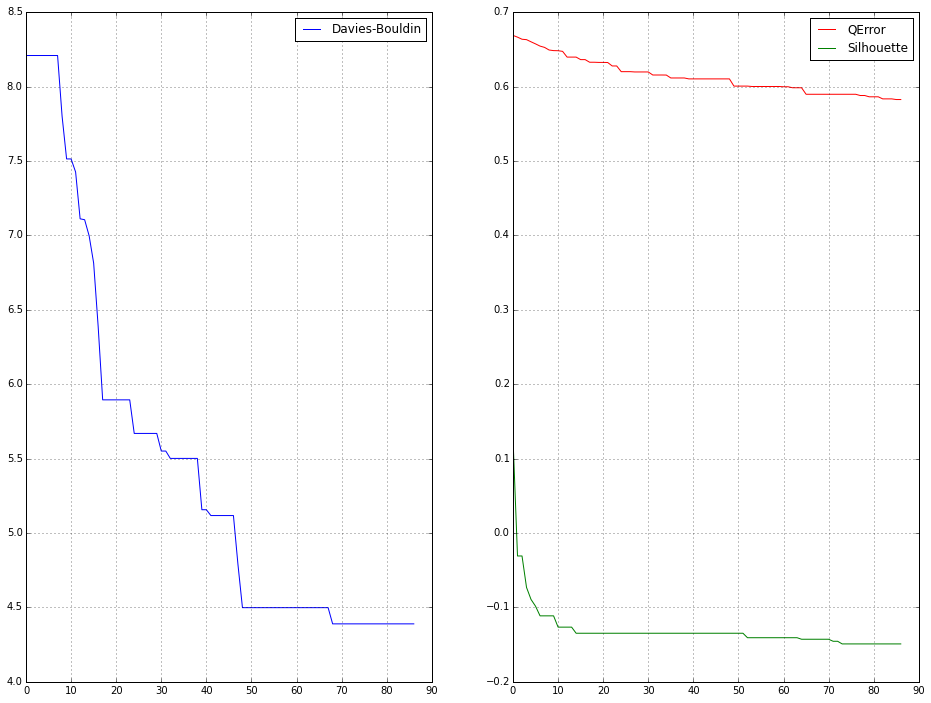

In [108]:
# # Exploración kernel k-means
#resulQUA.KK = runClusters(simCosine, WTCOR, range(2, 89), 1, cluster_texts_kernelKmeans)
#pickle.dump(resulQUA.KK, open("Output/resulQUA_Kernel.pickle", 'wb'))
resulQUA.KK = pickle.load(open("../Output/resulQUA_Kernel.pickle", 'rb'))
grafResult(resulQUA.KK)

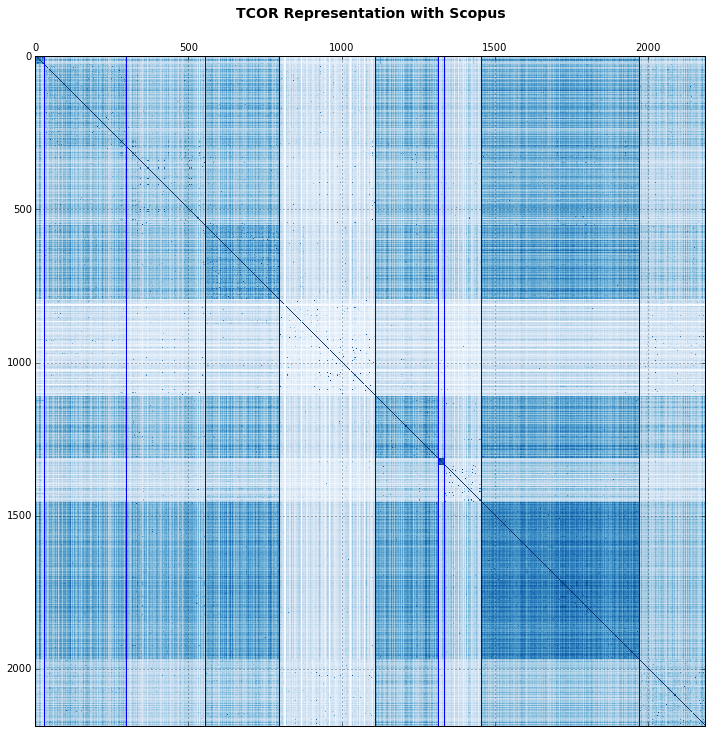

In [206]:
from Kernel_Kmeans import KernelKMeans
from sklearn.datasets import make_blobs

# # Clustering con k-means sklearn
def cluster_texts_kernelKmeans(tfidf_model, n_clus=3):
    # # Usando la funcion del paquete Kmeans de sklearn
    km_cluster = KernelKMeans(n_clusters = n_clus, max_iter=100, random_state=0, verbose=1, kernel = 'cosine')
    km_cluster.fit(tfidf_model)
    clustering = collections.defaultdict(list)
    centros    = collections.defaultdict(list)
    for idx, label in enumerate(km_cluster.labels_):
        clustering[label].append(idx)
        centros[label].append(tfidf_model[idx])
    return clustering, km_cluster.labels_, reevaluate_centers_sp(centros)

# # Representación matrix de Similitudes
#X, y = make_blobs(n_samples=1000, centers=5, random_state=0)
km = cluster_texts_kernelKmeans(WTCOR, n_clus = 10)
print(km[1])

# # Ordenando segun representación
data       = zip(np.array(listORF), range(len(np.array(listORF))))
data.sort(key=lambda tup: tup[0])
order_Mat  = [zz for ww,zz in data] 
km = [km[0], km[1][order_Mat], km[2]]
simCosine  = simCosine[order_Mat]
simCosine  = simCosine[:, order_Mat]

# # Matriz de similitud 
fit_data   = simCosine[np.argsort(km[1])]
fit_data   = fit_data[:, np.argsort(km[1])]

plt.matshow(fit_data.toarray(), cmap=plt.cm.Blues)
plt.grid()
plt.title('TCOR Representation with Scopus', fontsize=14, fontweight='bold')
contKm = collections.Counter(km[1]).items()
contKm.sort(key=lambda tup: tup[0])
contKm = np.cumsum([zz for ww, zz in contKm]).tolist()
contKm.pop(-1)
for ww in contKm:
    plt.axvline(ww, color = 'blue', alpha = 1)

In [146]:
# # Distancia al centro de clase.
total_distance = []
#WTCOR           = WTCOR[order_Mat]
for i in range(WTCOR.shape[0]):
    total_distance.append(dis_sim(WTCOR[i], centers[km[1][i]]))

# # Construcción salida final (Filtro por IND_PROYECTO)
datUN = pickle.load(open(outPath + 'datosFinal.pkl', 'rb')) 
datUN = datUN.loc[datUN['IND_PROYECTO'] != 0, :]
datUN = datUN.loc[~datUN['Indice_Busqueda'].duplicated(), :]
datUN = datUN.sort_values(by = 'Indice_Busqueda')
datUN['Cluster']    = km[1]
datUN['Dis_Center'] = total_distance

# # Salida a excel
datUN.to_excel("clKKmeans.xlsx", sheet_name = 'Cluster')

### Multidimensional scaling

/opt/anaconda/envs/mindlabenv/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


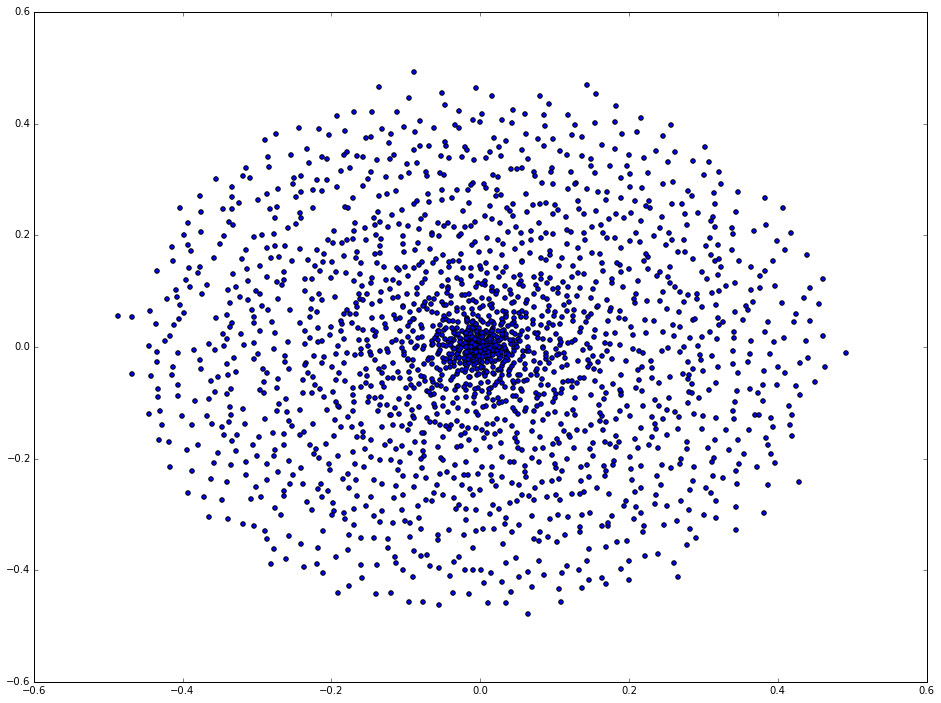

In [216]:
import os  # for os.path.basename
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.manifold import MDS

MDS()
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(simCosine.todense())  # shape (n_components, n_samples)
xs, ys = pos[:, 0], pos[:, 1]
plt.scatter(xs, ys)


In [218]:
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e', 
                  5: '#667500', 6: '#ff57e9', 7: '#5000d1', 8: '#9c9c9c', 9: '#cc5900'}
df = pd.DataFrame(dict(x=xs, y=ys, label = km[1])) 
groups = df.groupby('label')
groups
# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')


### Cluster con DPSO (Adaptación de https://github.com/dzotokan/bpso)

Definición de las principales clases y sus atributos

In [ ]:
class ParticleModel:
    _position       = None
    _velocity       = None
    _bestPosition   = None
    _nbBestPosition = None
    _fitness        = None
    
    def __init__(self):
        self._position       = None
        self._velocity       = None
        self._bestPosition   = None
        self._nbBestPosition = None
        self._fitness        = None

#---- Swarm representation
class SwarmModel:
    _particles              = None
    _neighbourhoods         = None
    _bestPosition           = None
    _bestPositionFitness    = None
    def __init__(self):
        self._particles = []
        self._neighbourhoods        = None
        self._bestPosition          = None
        self._bestPositionFitness   = None
        

#---- Neighbourhood representation    
class NeighbourhoodModel:
    _particles              = []
    _bestPosition           = None
    _bestPositionFitness    = None
    def __init__(self, particles):
        self._particles             = particles
        self._bestPosition          = None
        self._bestPositionFitness   = None



In [ ]:
class DiscreteParticleController:
    _solution       = None
    _MatSimilaridad = None
    nCluster        = None
    
    def __init__(self, solution, tfr_Mat, nCluster):
        self._solution   = solution
        self._MatSimilaridad = cosine_distance(tfr_Mat)
        self.nCluster    = nCluster

    def initParticle(self, model, dimensions):
        # Create position array
        model._position = np.random.randint(self.nCluster, size = dimensions) + 1
        # Create Velocity array
        model._velocity = (np.random.randint(self.nCluster, size = dimensions) + 1) / self.nCluster
        # Save best Position so far as current Position
        model._bestPosition = model._position
        self.updateFitness(model)

    def updateFitness(self, model):
        # Get Differences of vector
        hdist = coef_Silueta(self._MatSimilaridad, model._position)
        # Save it as best position if its better than previous best
        if hdist > model._fitness or model._fitness is None:
            model._bestPosition = np.copy(model._position)
            model._fitness = hdist

    def updatePosition(self, model):
        # VELOCITY NEEDS TO BE CONSTRICTED WITH VMAX
        # Get random coefficients e1 & e2
        c = 2.5
        e1 = np.random.rand()
        e2 = np.random.rand()
        vmax = 6
        # Apply equation to each component of the velocity, add it to corresponding position component
        for i, velocity in enumerate(model._velocity):
            velocity = velocity + c * e1 * (model._bestPosition[i] - model._position[i]) + c * e2 * (model._nbBestPosition[i] - model._position[i])
            if abs(velocity) > vmax and abs(velocity) is velocity: 
                velocity = vmax
            elif abs(velocity) > vmax:
                velocity = -vmax
            velocity = self.sigmoid(velocity)
            velocity = velocity / self.nCluster
            #print "vel:", velocity
            if np.random.rand(1) < velocity:
                model._position[i] = model._bestPosition[i]
            
    def sigmoid(self, x):
        return 1.0/(1.0 + np.exp(-(x)))

In [ ]:
class NeighbourhoodController:    
    def initNeighbourhoods(self, swarm, topology = "gbest"):
        if topology is "gbest":
            return [NeighbourhoodModel(swarm._particles)]
        elif topology is "lbest":
            neighbourhoods = []
            for idx, curParticle in enumerate(swarm._particles):
                previousParticle = None
                nextParticle = None
                if idx is 0:
                    # Previous is last, next is next
                    nextParticle = swarm._particles[idx + 1]
                    previousParticle = swarm._particles[len(swarm._particles) - 1]
                elif idx is len(swarm._particles) - 1:
                    # Previous is previous, next is first
                    nextParticle = swarm._particles[0]
                    previousParticle = swarm._particles[idx - 1]
                else:
                    # Previous is previous, next is next
                    nextParticle = swarm._particles[idx + 1]
                    previousParticle = swarm._particles[idx - 1]
                neighbourhoods.append(NeighbourhoodModel([previousParticle, curParticle, nextParticle]))
            return neighbourhoods

    def updateNeighbourhoodBestPosition(self, model):
        # Find the best one in the NB
        for curParticle in model._particles:
            if model._bestPositionFitness is None or (curParticle._fitness < model._bestPositionFitness and curParticle._fitness is not None):
                model._bestPositionFitness = curParticle._fitness
                model._bestPosition = np.copy(curParticle._bestPosition)

        # Save nb best position in particles nbBestPosition 
        for curParticle in model._particles:
            curParticle._nbBestPosition = np.copy(model._bestPosition)

class SwarmController:    

    _particleController      = None
    _neighbourhoodController = None
    
    def __init__(self, solution, tfr_Mat, nCluster):
        self._particleController      = DiscreteParticleController(solution, tfr_Mat, nCluster)                             
        self._neighbourhoodController = NeighbourhoodController()
    
    def initSwarm(self, swarm, topology = "gbest" , nParticles = 1, dimensions = 1):
        # Create Swarm
        for i in range(nParticles):
            newParticle = ParticleModel()
            self._particleController.initParticle(newParticle, dimensions)
            swarm._particles.append(newParticle)    
        swarm._neighbourhoods = self._neighbourhoodController.initNeighbourhoods(swarm, topology)
        self.updateSwarmBestPosition(swarm)
            

    def updateSwarmBestPosition(self, swarm):
        # Find swarm best position and save it in swarm
        for nb in swarm._neighbourhoods:
            self._neighbourhoodController.updateNeighbourhoodBestPosition(nb)
            if swarm._bestPositionFitness is None or nb._bestPositionFitness < swarm._bestPositionFitness:
                swarm._bestPositionFitness = nb._bestPositionFitness
                swarm._bestPosition =  np.copy(nb._bestPosition)
    
    # Update all particles in the swarm 
    def updateSwarm(self, swarm):
        for curParticle in swarm._particles:
            self._particleController.updatePosition(curParticle)
            self._particleController.updateFitness(curParticle)
        self.updateSwarmBestPosition(swarm)

In [ ]:

class CDPSOProblem():
    _plotPoints = []
    _topology       = None
    _dimensions     = None
    _popSize        = None
    _generations    = None

    def __init__(self,  nCluster, tfr_Mat, topology = "gbest"):
        print "\nProblem Solving: Discrete"
        # Problem parameters
        self._topology = topology
        solution  = np.random.randint(nCluster, size = tfr_Mat.shape[0]) + 1
        self._popSize = popSize = 50
        self._dimensions = dimensions  = len(solution)
        self._generations = generations = 100
        self._topology = topology
        
        # Swarm Initialization
        swarm   = SwarmModel()
        sc      = SwarmController(solution, tfr_Mat, nCluster)
        sc.initSwarm(swarm, topology, popSize, dimensions)
        
        # Output Results
        fitness = 1
        idx = 0
        for i in range(generations):
            sc.updateSwarm(swarm)
            if swarm._bestPositionFitness < fitness:
                fitness = swarm._bestPositionFitness
                idx = i
            gen = i+1
            fit = dimensions - (dimensions * swarm._bestPositionFitness)
            self._plotPoints.append( (gen, fit) )
#            self._plotPoints += (i+1, 1 - swarm._bestPositionFitness)
            print "Generation", i+1,"\t-> BestPos:", swarm._bestPosition, "\tBestFitness:", swarm._bestPositionFitness
        
        print "\n==================================================================="
        print "Dimensions:\t", dimensions
        print "Solution:\t", np.array(solution)
        print "Best Result:\t", swarm._bestPosition
        print "Best Fitness:\t", 1 - swarm._bestPositionFitness, "in %d" % idx, " iteration out of %d" % generations
        print "Number of bits out of place: %d" % (dimensions * swarm._bestPositionFitness)
        print "==================================================================="
    def plotResults(self):
#        print self._plotPoints
        x = []
        y = []
        for (generation, fitness) in self._plotPoints:
            x.append(fitness)
            y.append(generation)
#            print "%d" % (fitness)
        pyl.plot(x, y)
        
        pyl.grid(True)
        pyl.title('Optimizing %dD Bit Vector (Topology: %s) ' % (self._dimensions, self._topology))
        pyl.xlabel('Fitness (Number of Bits in Place) - Out of %d' % (24))
        pyl.ylabel('Generation (i)')
        pyl.savefig('simple_plot')
        pyl.show()
        
    def plotResults(self):
#        print self._plotPoints
        x = []
        y = []
        for (generation, fitness) in self._plotPoints:
            x.append(fitness)
            y.append(generation)
#            print "%d" % (fitness)
        pyl.plot(x, y)
        
        pyl.grid(True)
        pyl.title('Optimizing %dD Bit Vector (Topology: %s) ' % (self._dimensions, self._topology))
        pyl.xlabel('Fitness (Number of Bits in Place) - Out of %d' % (24))
        pyl.ylabel('Generation (i)')
        pyl.savefig('simple_plot')
        pyl.show()

In [ ]:
cpsoProblem = CDPSOProblem(nCluster = 4, tfr_Mat = tfs, topology = "gbest")

### Clustering dataset cleared

In [33]:
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine

outPath = "../Output/"
WTCOR   = pickle.load(open(outPath + 'WTCOR_RE.pickle', 'rb'))
print(WTCOR.shape)

# # Calculando Similitud de Coseno
pathScose = outPath + 'simCosine_RE.pickle'
if os.path.exists(pathScose):
    simCosine_re = pickle.load(open(pathScose, 'rb'))
    print("--- Load cosine similarity\n")
else:
    simCosine_re = 1 - pairwise_distances(WTCOR, metric="cosine")
    simCosine_re = sparse.csr_matrix(simCosine)
    pickle.dump(simCosine_re, open(pathScose, 'wb'))
    print("--- Save cosine similarity\n")

(2138, 37069)
--- Load cosine similarity



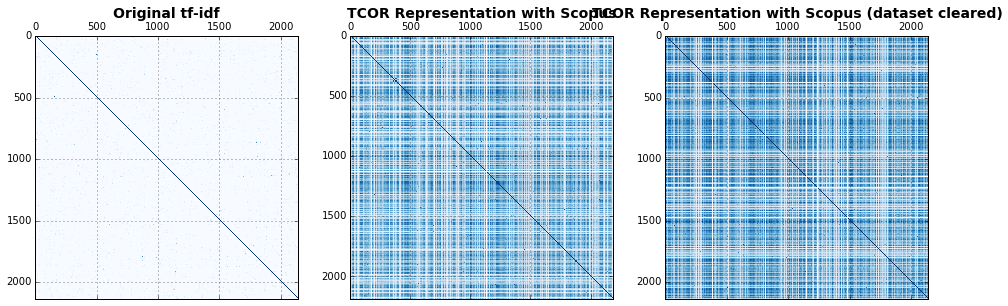

In [11]:
# # Representación Original
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
mpl.rcParams['figure.figsize'] = 16, 12

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False)
ax1.matshow(sim_orig.toarray(), cmap=plt.cm.Blues)
ax1.grid()
ax1.set_title('Original tf-idf', fontsize=14, fontweight='bold')
ax2.matshow(simCosine.toarray(), cmap=plt.cm.Blues)
ax2.grid()
ax2.set_title('TCOR Representation with Scopus', fontsize=14, fontweight='bold')
ax3.matshow(simCosine_re.toarray(), cmap=plt.cm.Blues)
ax3.grid()
ax3.set_title('TCOR Representation with Scopus (dataset cleared)', fontsize=14, fontweight='bold')

In [ ]:
resulQUA = runClusters(simCosine_re, WTCOR, range(2, 91), 1, cluster_texts_spectral)
pickle.dump(resulQUA, open("../Output/resulQUA_Spectral_RE.pickle", 'wb'))

---- evaluado para num_clusters =  2
2
2138
---- evaluado para num_clusters = 

In [2]:
resulQUA = pickle.load(open("../Output/resulQUA_Spectral_RE.pickle", 'rb'))
resulQUAII = pickle.load(open("../Output/resulQUA_Kernel_RE.pickle", 'rb'))

def grafResult(vecResul, label = None):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False)
    for ii in range(len(vecResul)):
        resulQUA = vecResul[ii]
        auxLine  = ['solid', 'dashed', 'dashdot', 'dotted', '-', '--', '-.', ':']
        id_1 = np.array(resulQUA[["Davies-Bouldin"]])
        id_2 = np.array(resulQUA[["QError"]])
        id_3 = np.array(resulQUA[["Silhouette"]])
        ax1.plot(id_1, label = label[ii], linestyle = auxLine[ii])
        ax1.set_title("Davies-Bouldin")
        ax1.grid()
        ax1.legend()
        ax2.plot(id_2, color = 'red', label= label[ii], linestyle = auxLine[ii])
        ax2.set_title("QError")
        ax2.grid()
        ax2.legend()
        ax3.plot(id_3, color = 'green', label=label[ii], linestyle = auxLine[ii])
        ax3.set_title("Silhouette")
        ax3.grid()
        ax3.legend()

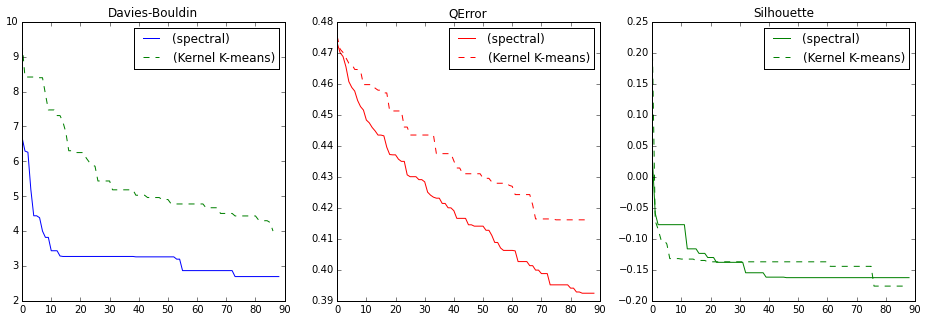

In [5]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 16, 5
grafResult([resulQUA, resulQUAII], ['(spectral)', '(Kernel K-means)'])

In [31]:
resulQUA_Ant = pickle.load(open("../Output/resulQUA_Spectral2.pickle", 'rb'))
comResult(resulQUA_Ant, resulQUA)

In [ ]:
espec = cluster_texts_spectral(simCosine_re, WTCOR, n_clus = 10)
# # Distancia al centro de clase.
total_distance = []
centers        = espec[2]
#WTCOR           = WTCOR[order_Mat]
for i in range(WTCOR.shape[0]):
    total_distance.append(dis_sim(WTCOR[i], centers[espec[1][i]]))

# # Construcción salida final (Filtro por IND_PROYECTO)
datUN = pickle.load(open(outPath + 'datosFinal_RE.pkl', 'rb')) 
datUN = datUN.loc[datUN['IND_PROYECTO'] != 0, :]
datUN = datUN.loc[~datUN['Indice_Busqueda'].duplicated(), :]
datUN = datUN.sort_values(by = 'Indice_Busqueda')
datUN['Cluster']    = espec[1]
datUN['Dis_Center'] = total_distance
datUN.to_excel("clSpectral_RE.xlsx", sheet_name = 'Cluster')

In [32]:
fit_data   = simCosine_re[np.argsort(espec[1])]
fit_data   = fit_data[:, np.argsort(espec[1])]

plt.matshow(fit_data.toarray(), cmap=plt.cm.Blues)
plt.grid()
plt.title('Final Representation Spectral', fontsize=14, fontweight='bold')

### Kernel K-Means

Converged at iteration 23
[0 1 4 ..., 8 3 4]


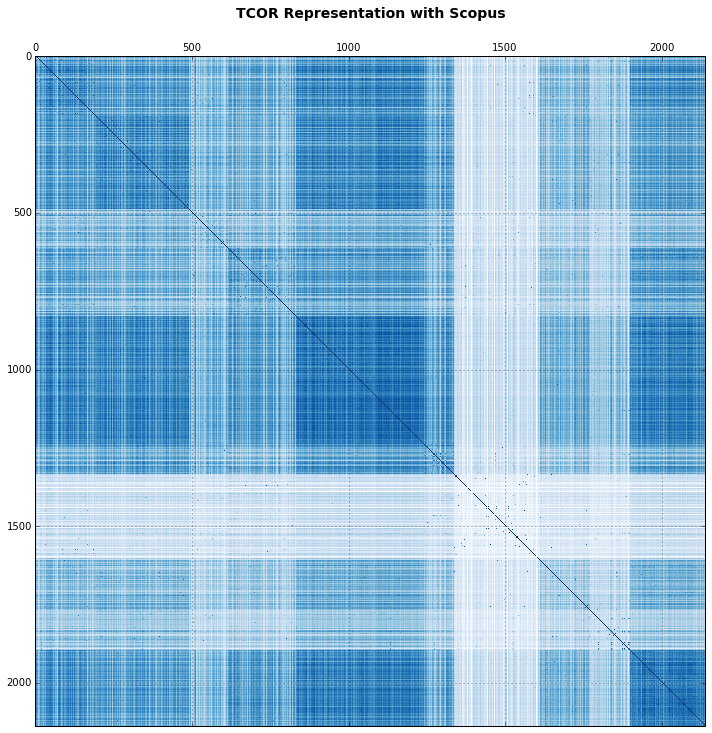

In [40]:
from Kernel_Kmeans import KernelKMeans
from sklearn.datasets import make_blobs

sin_duplicados, tfs, texts, listORF = pickle.load(open(outPath + 'tfidforig_RE.pickle', 'rb'))
# # Representación matrix de Similitudes
#X, y = make_blobs(n_samples=1000, centers=5, random_state=0)
km = cluster_texts_kernelKmeans(WTCOR, n_clus = 10)
print(km[1])

# # Matriz de similitud 
fit_data   = simCosine_re[np.argsort(km[1])]
fit_data   = fit_data[:, np.argsort(km[1])]

plt.matshow(fit_data.toarray(), cmap=plt.cm.Blues)
plt.grid()
plt.title('TCOR Representation with Scopus', fontsize=14, fontweight='bold')

In [ ]:
resulQUA.KK = runClusters(simCosine_re, WTCOR, range(2, 89), 1, cluster_texts_kernelKmeans)
pickle.dump(resulQUA.KK, open("../Output/resulQUA_Kernel_RE.pickle", 'wb'))

---- evaluado para num_clusters =  2
Converged at iteration 12
2

In [43]:
total_distance = []
centers        = km[2]
#WTCOR           = WTCOR[order_Mat]
for i in range(WTCOR.shape[0]):
    total_distance.append(dis_sim(WTCOR[i], centers[espec[1][i]]))

# # Save dataSet
datUN = pickle.load(open(outPath + 'datosFinal_RE.pkl', 'rb')) 
datUN = datUN.loc[datUN['IND_PROYECTO'] != 0, :]
datUN = datUN.loc[~datUN['Indice_Busqueda'].duplicated(), :]
datUN = datUN.sort_values(by = 'Indice_Busqueda')
datUN['Cluster']    = km[1]
datUN['Dis_Center'] = total_distance
datUN.to_excel("clKKMeans_RE.xlsx", sheet_name = 'Cluster')